**IMPORTING LIBRARIES AND DATASET**

In [1]:
import numpy as np 
import pandas as pd
import os
data_covid=pd.read_csv('../input/covid19-in-india/covid_19_india.csv')
import matplotlib.pyplot as plt
from datetime import datetime
import datetime as dt
from datetime import date
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as pl
from statsmodels.tsa.statespace.sarimax import SARIMAX 

**ABOUT DATA**

In [2]:
print(data_covid.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5161 entries, 0 to 5160
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Sno                       5161 non-null   int64 
 1   Date                      5161 non-null   object
 2   Time                      5161 non-null   object
 3   State/UnionTerritory      5161 non-null   object
 4   ConfirmedIndianNational   5161 non-null   object
 5   ConfirmedForeignNational  5161 non-null   object
 6   Cured                     5161 non-null   int64 
 7   Deaths                    5161 non-null   int64 
 8   Confirmed                 5161 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 363.0+ KB
None


**COVID Data for Delhi**

In [3]:
delhi_data=data_covid.loc[data_covid['State/UnionTerritory']=='Delhi']
print(delhi_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165 entries, 34 to 5134
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Sno                       165 non-null    int64 
 1   Date                      165 non-null    object
 2   Time                      165 non-null    object
 3   State/UnionTerritory      165 non-null    object
 4   ConfirmedIndianNational   165 non-null    object
 5   ConfirmedForeignNational  165 non-null    object
 6   Cured                     165 non-null    int64 
 7   Deaths                    165 non-null    int64 
 8   Confirmed                 165 non-null    int64 
dtypes: int64(4), object(5)
memory usage: 12.9+ KB
None


**Converting into time-series data**

In [4]:
df=delhi_data[['Date','Confirmed']]
df['Date']=pd.to_datetime(df['Date'], dayfirst=True)
df.set_index('Date',inplace=True)
df.columns=['Confirmed']
df=df[df['Confirmed']!=0]
print(df.describe())

           Confirmed
count     165.000000
mean    43261.145455
std     52273.013389
min         1.000000
25%      1069.000000
50%     12319.000000
75%     92175.000000
max    148504.000000


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# IDENTIFICATION

* **PLOTTING DATA**

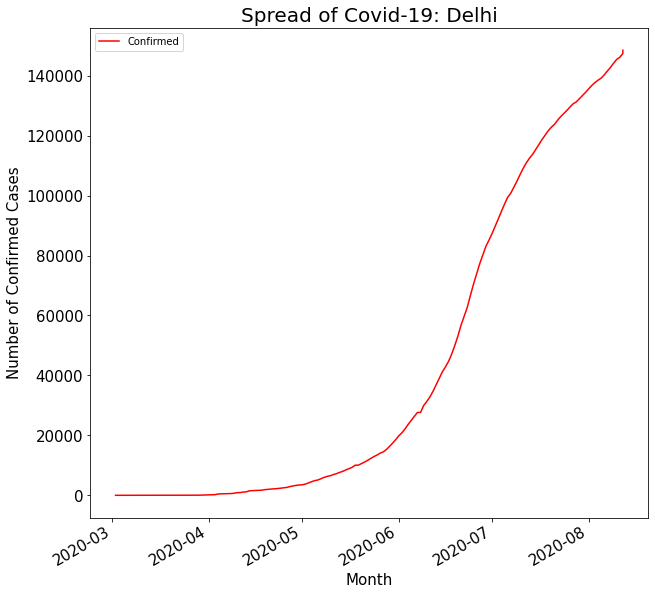

In [5]:
ax=df.plot(figsize=(10,10),color='Red',fontsize=15)
ax.set_xlabel('Month', fontsize=15)
ax.set_ylabel('Number of Confirmed Cases',fontsize=15)
ax.set_title('Spread of Covid-19: Delhi',fontsize=20)
plt.style.use('fivethirtyeight')
plt.show()

* **AUGMENTED DICKEY-FULLER TEST**

In [6]:
#Checking for Stationarity
res=adfuller(df)
print('p-value=',res[1])

p-value= 0.8472189025857084


*p-value>>0.05, hence null hypothesis true: series is non-stationary*


* **TRANSFORM**

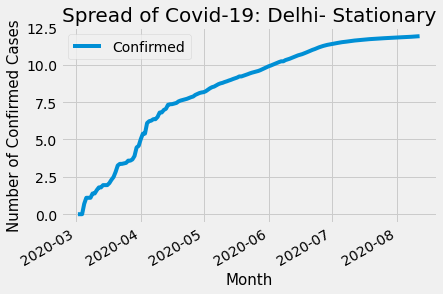

p-value= 0.029448490431180717


In [7]:
#Convert to stationary series by- 

#Taking log transform  
df_log=np.log(df)

#Plotting stationary series
ax1=df_log.plot()
ax1.set_xlabel('Month', fontsize=15)
ax1.set_ylabel('Number of Confirmed Cases',fontsize=15)
ax1.set_title('Spread of Covid-19: Delhi- Stationary',fontsize=20)
plt.style.use('fivethirtyeight')
plt.show()

#Checking for stationarity 
check=adfuller(df_log)
print('p-value=',check[1])

* **Split into train-test set**

In [8]:
df_train=df_log.iloc[:len(df)-50]
df_test=df_log.iloc[len(df)-50:]

* **COMPUTE AND PLOT ACF AND PACF**

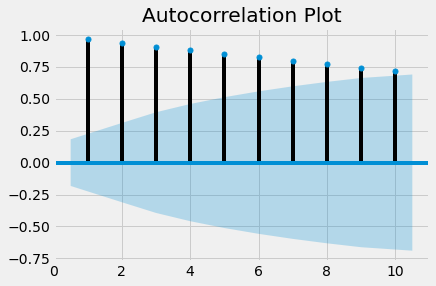

In [9]:
#Plotting ACF
pl.plot_acf(df_train,lags=10,zero=False)
plt.title('Autocorrelation Plot')
plt.show()


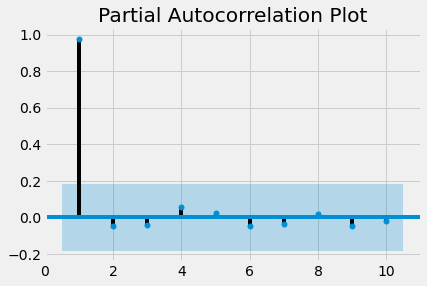

In [10]:
#Plotting PACF
pl.plot_pacf(df_train,lags=10,zero=False)
plt.title('Partial Autocorrelation Plot')
plt.show()

*ACF plot tails off, while PACF plot cuts after lag. Hence AR(p) model suitable*

# **ESTIMATION**

* **TRAIN MODEL**

In [11]:
#Finding the best model 
param=[]
for p in range(4):
    for q in range(4):
        model=SARIMAX(df_train,order=(p,0,q),trend='c')
        results=model.fit()
        param.append([p,q,results.aic,results.bic])
res=pd.DataFrame(param,columns=['p','q','aic','bic'])
print(res.sort_values('aic'))


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.

    p  q         aic         bic
9   2  1 -135.101740 -121.377079
14  3  2 -128.098394 -108.883869
10  2  2 -124.837519 -108.367926
11  2  3 -122.434998 -103.220473
15  3  3 -116.671910  -94.712453
12  3  0 -115.198979 -101.474319
7   1  3 -113.104591  -96.634999
8   2  0 -109.195670  -98.215941
13  3  1 -105.706002  -89.236410
6   1  2 -101.332479  -87.607818
5   1  1  -99.198342  -88.218613
4   1  0  -79.659637  -71.424841
3   0  3  233.391265  247.115926
2   0  2  322.444628  333.424357
1   0  1  449.513468  457.748264
0   0  0  597.685078  603.174942


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [12]:
#Training the best model
model=SARIMAX(df_train,order=(2,0,1),trend='c')
results=model.fit()
print(results.aic)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


-135.1017397440214


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


# **MODEL DIAGNOSTICS**

In [13]:
#Mean absolute error
residuals=results.resid
mae=np.mean(np.abs(residuals))
print(mae)

0.09985859613045267


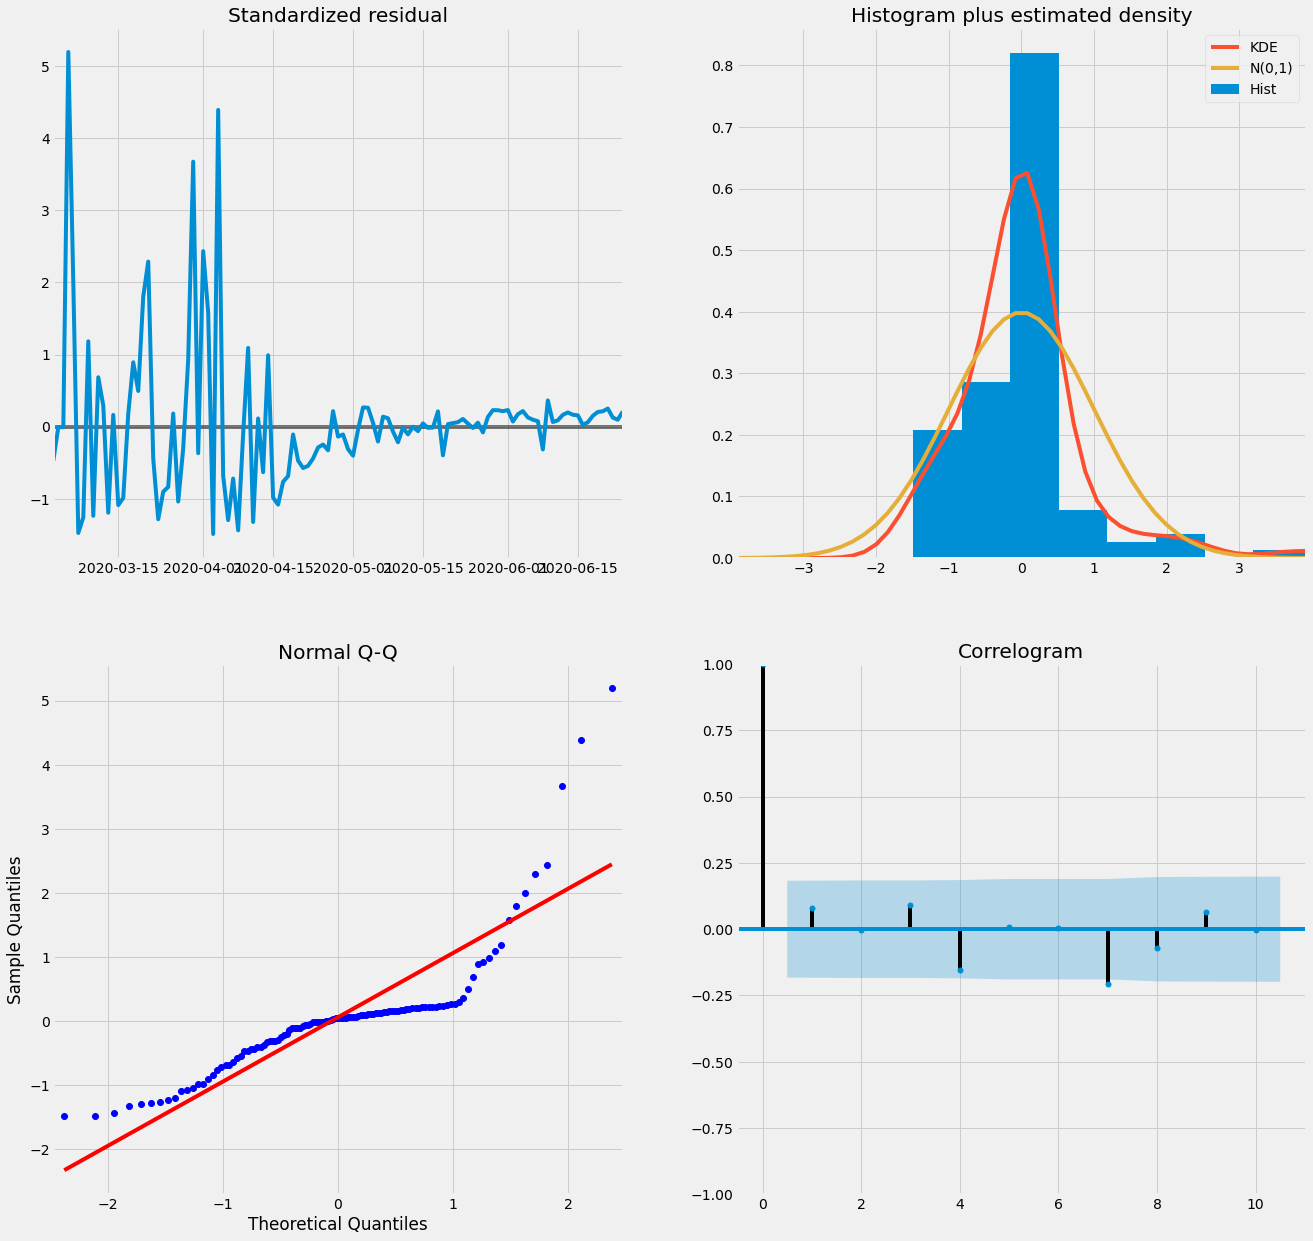

In [14]:
#Plotting diagnostics
results.plot_diagnostics(figsize=(20,20))
plt.show()

In [15]:
#Summary of results
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:              Confirmed   No. Observations:                  115
Model:               SARIMAX(2, 0, 1)   Log Likelihood                  72.551
Date:                Fri, 14 Aug 2020   AIC                           -135.102
Time:                        08:53:59   BIC                           -121.377
Sample:                    03-02-2020   HQIC                          -129.531
                         - 06-24-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.003      0.151      0.880      -0.006       0.007
ar.L1          1.9934      0.010    191.227      0.000       1.973       2.014
ar.L2         -0.9936      0.010    -95.843      0.0

# **FORECASTING**

In [16]:
#Predicted values
predictions=results.predict(1,df.shape[0])

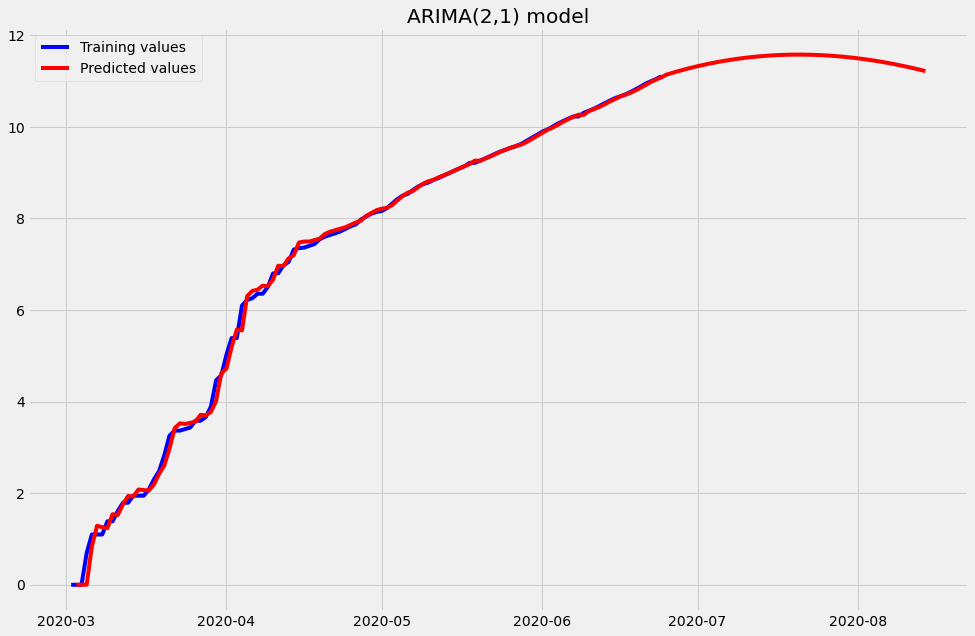

In [17]:
#Plotting data
plt.figure(figsize=(15,10))
plt.plot(df_log[:len(df)-50],label = "Training values",color='blue')
plt.plot(predictions,color='red',label='Predicted values')
plt.title('ARIMA(2,1) model')
plt.legend()
plt.show()